# Beta Variational Autoencoder
This notebook implements Beta variational autoencoder. It is just for exploring the concept rather than aiming for a good results.

This is inspired by Dr Jorge Cardoso's lecture at King's College London.

## Import general library and define common structure

In [1]:
# Import library and set up environment
import os as os
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision
import torch.optim as optim
from torchvision import transforms
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
num_workers = torch.cuda.device_count()
print("Number of GPU workers available:", num_workers)

cuda
Number of GPU workers available: 2


In [3]:
# Create a class that aid in training and testing
class Model_Wrapper:
    def __init__(self, model, optimizer, loss_function, device):
        '''Start the model and store important object'''
        self.model = model
        self.optimizer = optimizer
        self.loss_function = loss_function
        self.device = device
        self.total_train_epoch = 0
        self.train_loss_list = []
        self.calculated_metrics = None

    def push_to_device(self):
        self.model = self.model.to(self.device)
        self.loss_function = self.loss_function.to(self.device)

    def train(self, num_epochs, train_loader):
        '''Train model'''
        # Start training
        expected_total_epoch = self.total_train_epoch + num_epochs
        for epoch in range(num_epochs):
            self.model.train()
            for i, (data, labels) in enumerate(train_loader, 0):
                # Push data to GPU, clear gradient, calculate loss, backpropagation
                data = data.to(self.device)
                labels = labels.to(self.device)
                # Zero gradient
                self.optimizer.zero_grad()
                # Forward
                output = self.model(data)
                # Calculate the loss
                loss = self.loss_function(output, labels)
                # Calculate the gradient
                loss.backward()
                # Update the weight
                self.optimizer.step()
                # Store the loss value
                self.train_loss_list.append(loss.item())
                # print the loss
                if i % 50 == 0:
                    print(f"Epoch: {self.total_train_epoch+1}/{expected_total_epoch}; Data {i*len(labels)}/{len(train_loader.dataset)}; Loss: {loss.item()}")
            self.total_train_epoch += 1

    def plot_train_loss(self, plot_title = "Loss value during training"):
        """Plot the loss value during training"""
        # Add plot
        _, ax = plt.subplots()
        ax.plot(range(len(self.train_loss_list)), self.train_loss_list)
        # Add a title and labels
        ax.set_title(plot_title)
        ax.set_xlabel('Time')
        ax.set_ylabel('Loss value')

    def test(self, test_loader):
        """Test on test data set"""
        total_loss=[]
        # Test the model
        self.model.eval()
        for i, (data, labels) in enumerate(test_loader, 0):
            # Push data to GPU, predict, and calculate the loss
            data = data.to(device)
            labels = labels.to(device)
            # Predict
            output = self.model(data)
            # Calculate the loss
            loss = self.loss_function(output, labels)
            # Append the loss
            total_loss.append(loss.item())
            # Calculate performance
            self.calculate_metrics(labels, output)
        # print the loss and metrics
        print(f"Loss: {round(np.array(total_loss).mean(),4)}")
        for metric_name, metric_value in self.calculated_metrics.items():
            print(metric_name, ": ", round(np.array(metric_value).mean(),4), sep="")

    def calculate_metrics(self, labels, output):
        """Edit here to calculate the metrics"""
        """Should be individualized"""
        # Make prediction
        if (self.calculated_metrics == None):
            self.calculated_metrics = {}

## Load the dataset

In [6]:
# Set the directory path
directory = './data'
# Load the dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5])])
training = torchvision.datasets.MNIST(root=directory, train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(training, batch_size=32, shuffle=True, num_workers=2)
# Create dataloader
testing = torchvision.datasets.MNIST(root=directory, train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testing, batch_size=32, shuffle=False, num_workers=2)
# Label the classes
classes = ('0', '1', '2', '3',
          '4', '5', '6', '7', '8', '9')
# List all files in the directory
files = os.listdir(directory)
# Print the file names
for file in files:
    print(file)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 33474969.48it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 996927.75it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 10477242.24it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2513262.37it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

MNIST


## Define some basic network block

In [7]:
# Define a resdidual block t
class ResBlock(nn.Module):
  def __init__(self, in_channels, out_channels, mode="level"):
    '''
      in_channels - integer - the number of feature channels the first
                              convolution will receive
      out_channels - integer - the number of feature channels the last
                               convolution will output
      mode - string - defines what the block will do
           - "upsample" means the block wil double the spatial size
           - "downsample" means the block will halve the spatial size
           - "level" means the block will not change the spatial dimension
    '''
    super(ResBlock, self).__init__()
    if mode == "upsample":
      self.main_forward = nn.Sequential(
          nn.ConvTranspose2d(
              in_channels=in_channels,
              out_channels=out_channels,
              kernel_size=4,
              stride=2,
              padding=1,
          ),
          nn.LeakyReLU(inplace=True),
          nn.Conv2d(
              in_channels=out_channels,
              out_channels=out_channels,
              kernel_size=3,
              stride=1,
              padding=1,
          ),         
      )
      self.residual_forward = nn.ConvTranspose2d(
          in_channels=in_channels,
          out_channels=out_channels,
          kernel_size=4,
          stride=2,
          padding=1,
      )
    else:
      self.main_forward = nn.Sequential(
          nn.Conv2d(
              in_channels=in_channels,
              out_channels=out_channels,
              kernel_size=3,
              stride=2 if mode == "downsample" else 1,
              padding=1,
          ),
          nn.LeakyReLU(inplace=True),
          nn.Conv2d(
              in_channels=out_channels,
              out_channels=out_channels,
              kernel_size=3,
              stride=1,
              padding=1,
          ),         
      )
      self.residual_forward = nn.Conv2d(
          in_channels=in_channels,
          out_channels=out_channels,
          kernel_size=3,
          stride=2 if mode == "downsample" else 1,
          padding=1,
      )
#     self.activation = nn.LeakyReLU(inplace=True)
  def forward(self, x):
    out = self.main_forward(x)
    x = out + self.residual_forward(x)
    return x

# Test
test = ResBlock(1, 3, "downsample")
x = torch.rand((100, 1, 28, 28))
print(x.size())
print(test(x).size())

torch.Size([100, 1, 28, 28])
torch.Size([100, 3, 14, 14])


In [8]:
# Define a multilayer perceptron
class MLP(nn.Module):
    def __init__(self, *number_of_features):
        super(MLP, self).__init__()
        assert len(number_of_features) > 1, "MLP input length is not good"
        # Dict that store the layers
        linear_dict = OrderedDict()
        i = -1
        for i in range(len(number_of_features) - 2):
            linear_dict[f"Linear_layer_{i+1}"] = nn.Linear(
                in_features = number_of_features[i],
                out_features = number_of_features[i+1],
            )
            linear_dict[f"Batch_norm_{i+1}"] = nn.BatchNorm1d(number_of_features[i+1])
            linear_dict[f"Relu_{i}"] = nn.LeakyReLU()
        i+=1
        # Last layer
        linear_dict[f"Linear_layer_{i+1}"] = nn.Linear(
            in_features = number_of_features[i],
            out_features = number_of_features[i+1],
        )
        # Combine into one        
        self.all_linear = nn.Sequential(linear_dict)
    def forward(self, x):
        return self.all_linear(x)

# Test
test = MLP(*[3, 5, 7])
x = torch.rand((100, 3))
print(x.size())
print(test(x).size())

torch.Size([100, 3])
torch.Size([100, 7])


# Beta-VAE network

In [125]:
def calculate_KL_loss(mu, logvar):
    return -0.5*(1 + logvar - mu**2 - torch.exp(logvar)).mean()

class VAE(nn.Module):
    def __init__(self, in_channels, image_size = (28, 28), latent_size = [32]):
        """
        in_channels - integer: number of channels of input image
        image_size - tuple: size of image
        latent_size - integer: length of latent vector
        depth - integer: how many time the network downsample the image
        length - integr: how many CNN will the image underwent before downsampled,
        
        """
        super(VAE, self).__init__()
        
        # Variable for storing KL loss
        self.loss_KL = 0

        ##### Encoder
        encoder = OrderedDict()
        image_size = torch.tensor(image_size)
        latent_size.insert(0, image_size.prod().item()*in_channels)
        
        if len(latent_size) >2:        
            self.latent_encoder = nn.Sequential(
                MLP(*latent_size[:-1]),
                nn.LeakyReLU()
            )
        elif len(latent_size) == 2:
            self.latent_encoder = nn.Identity()
                
        # Linear layer to get the mean and logvariance of the latent space distribution
        self.mu = nn.Linear(
            in_features=latent_size[-2],
            out_features=latent_size[-1],
        )
        self.logvar = nn.Linear(
            in_features=latent_size[-2],
            out_features=latent_size[-1],
        )
        ##### Latent space decoder
        self.latent_decoder = nn.Sequential(
            MLP(*latent_size[::-1]),
            nn.Tanh()
        )
        
        ##### Store the image size to reconstruct it later
        self.latent_image_size = (-1, in_channels, *image_size.tolist())
        
    def my_encode(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.latent_encoder(x)
        logvar = self.logvar(x)
        mu = self.mu(x)
        # Store KL loss
        self.loss_KL = calculate_KL_loss(mu, logvar)
        if self.training:
            x = mu + torch.exp(0.5*logvar)*torch.randn_like(logvar)
        else:
            x = mu
        return x

    def my_decode(self, x):
        x = self.latent_decoder(x)
        x = x.view(self.latent_image_size)
        return x
    
    def forward(self, x):
        x = self.my_encode(x)
        x = self.my_decode(x)
        return x
    
# Test
in_channels = 1
latent_size = [200, 200]
depth = 1
length = 2
image_size = (28, 28)
test = VAE(in_channels, image_size, latent_size)

x = torch.rand((100, 1, 28, 28))
print(x.size())
print(test(x).size())

# plt.imshow(test(x)[0,0].detach().numpy())

torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])


In [103]:
in_channels = 1
image_size = (28, 28)
latent_size = [1024, 512, 256]
learning_rate = 1e-3
betas = (0.9, 0.999)

model = VAE(in_channels, image_size, latent_size)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas = betas)
loss_func = nn.SmoothL1Loss()

In [104]:
class VAE_Model_Wrapper(Model_Wrapper):
    def train(self, num_epochs, train_loader, beta, plot_period = 200):
        '''Train model'''
        # Start training
        expected_total_epoch = self.total_train_epoch + num_epochs
        for epoch in range(num_epochs):
            self.model.train()
            for i, (data, labels) in enumerate(train_loader, 0):
                # Push data to GPU, clear gradient, calculate loss, backpropagation
                data = data.to(self.device)
                labels = labels.to(self.device)
                # Zero gradient
                self.optimizer.zero_grad()
                # Forward
                output = self.model(data)
                # Calculate the loss
                loss = self.loss_function(output, data) + beta*self.model.loss_KL
                # Calculate the gradient
                loss.backward()
                # Update the weight
                self.optimizer.step()
                # Store the loss value
                self.train_loss_list.append(loss.item())
                # print the loss
                if i % plot_period == 0:
                    print(f"Epoch: {self.total_train_epoch+1}/{expected_total_epoch}; Data {i*len(labels)}/{len(train_loader.dataset)}; Loss: {loss.item()}")
            self.total_train_epoch += 1

    def test(self, test_loader, beta):
        """Test on test data set"""
        total_loss=[]
        # Test the model
        self.model.eval()
        for i, (data, labels) in enumerate(test_loader, 0):
            # Push data to GPU, predict, and calculate the loss
            data = data.to(device)
            labels = labels.to(device)
            # Predict
            output = self.model(data)
            # Calculate the loss
            loss = self.loss_function(output, data) + beta*self.model.loss_KL
            # Append the loss
            total_loss.append(loss.item())
            # Calculate performance
            self.calculate_metrics(labels, output)
        # print the loss and metrics
        print(f"Loss: {round(np.array(total_loss).mean(),4)}")
        for metric_name, metric_value in self.calculated_metrics.items():
            print(metric_name, ": ", round(np.array(metric_value).mean(),4), sep="")

net = VAE_Model_Wrapper(model, optimizer, loss_func, device)
net.push_to_device()

In [105]:
beta = 1
net.train(2, train_loader, beta)

Epoch: 1/2; Data 0/60000; Loss: 0.5139083862304688
Epoch: 1/2; Data 6400/60000; Loss: 0.12071606516838074
Epoch: 1/2; Data 12800/60000; Loss: 0.11435952037572861
Epoch: 1/2; Data 19200/60000; Loss: 0.117677241563797
Epoch: 1/2; Data 25600/60000; Loss: 0.11666018515825272
Epoch: 1/2; Data 32000/60000; Loss: 0.11653389036655426
Epoch: 1/2; Data 38400/60000; Loss: 0.10909690707921982
Epoch: 1/2; Data 44800/60000; Loss: 0.1073240339756012
Epoch: 1/2; Data 51200/60000; Loss: 0.11409875750541687
Epoch: 1/2; Data 57600/60000; Loss: 0.10659822821617126
Epoch: 2/2; Data 0/60000; Loss: 0.10855941474437714
Epoch: 2/2; Data 6400/60000; Loss: 0.11351454257965088
Epoch: 2/2; Data 12800/60000; Loss: 0.09811682254076004
Epoch: 2/2; Data 19200/60000; Loss: 0.10465037077665329
Epoch: 2/2; Data 25600/60000; Loss: 0.10184377431869507
Epoch: 2/2; Data 32000/60000; Loss: 0.10294583439826965
Epoch: 2/2; Data 38400/60000; Loss: 0.11384984850883484
Epoch: 2/2; Data 44800/60000; Loss: 0.1100650355219841
Epoch: 

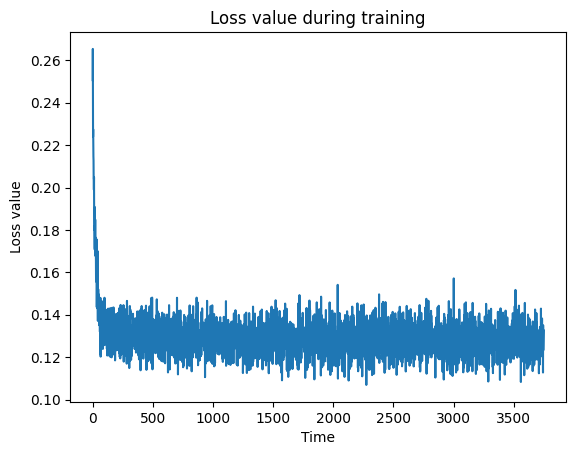

In [94]:
net.plot_train_loss()

In [95]:
net.test(test_loader, beta)

Loss: 0.1309


In [106]:
image, labels = next(iter(test_loader))
result = net.model(image.to(device))
result = result.detach().cpu()

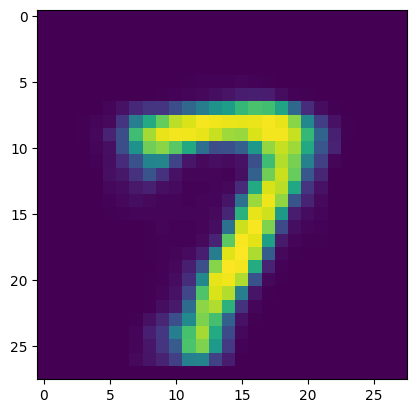

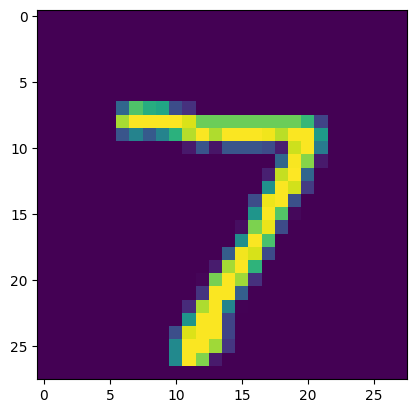

In [109]:
plt.imshow(result[0,0,:,:])
plt.show()
plt.imshow(image[0,0,:,:])
plt.show()

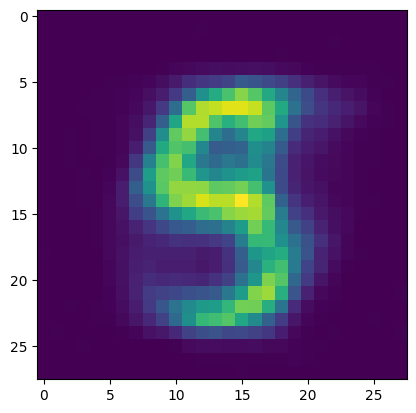

In [134]:
# Sample from the latent space
latent_size = [1024, 512, 256]
net.model.eval()
result = net.model.my_decode(torch.rand((1, latent_size[-1])).to(device))
result = result.detach().cpu()
plt.imshow(result[0,0,:,:])
plt.show()

# AE network
Just remove the KL loss function from the network above

In [174]:
class my_AE(nn.Module):
    def __init__(self, in_channels, image_size = (28, 28), latent_size = [32]):
        """
        in_channels - integer: number of channels of input image
        image_size - tuple: size of image
        latent_size - integer: length of latent vector
        depth - integer: how many time the network downsample the image
        length - integr: how many CNN will the image underwent before downsampled,
        
        """
        super(my_AE, self).__init__()
        
        # Variable for storing KL loss
        self.loss_KL = 0

        ##### Encoder
        encoder = OrderedDict()
        image_size = torch.tensor(image_size)
        latent_size.insert(0, image_size.prod().item()*in_channels)
        
        if len(latent_size) >2:        
            self.latent_encoder = nn.Sequential(
                MLP(*latent_size[:-1]),
                nn.LeakyReLU()
            )
        elif len(latent_size) == 2:
            self.latent_encoder = nn.Identity()
                
        # Linear layer to get the mean and logvariance of the latent space distribution
        self.mu = nn.Linear(
            in_features=latent_size[-2],
            out_features=latent_size[-1],
        )
        self.logvar = nn.Linear(
            in_features=latent_size[-2],
            out_features=latent_size[-1],
        )
        ##### Latent space decoder
        self.latent_decoder = nn.Sequential(
            MLP(*latent_size[::-1]),
            nn.Tanh()
        )
        
        ##### Store the image size to reconstruct it later
        self.latent_image_size = (-1, in_channels, *image_size.tolist())
        
    def my_encode(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.latent_encoder(x)
#         logvar = self.logvar(x)
        x = self.mu(x)
#         # Store KL loss
#         self.loss_KL = calculate_KL_loss(mu, logvar)
#         if self.training:
#             x = mu + torch.exp(0.5*logvar)*torch.randn_like(logvar)
#         else:
#             x = mu
        return x

    def my_decode(self, x):
        x = self.latent_decoder(x)
        x = x.view(self.latent_image_size)
        return x
    
    def forward(self, x):
        x = self.my_encode(x)
        x = self.my_decode(x)
        return x
    
# Test
in_channels = 1
latent_size = [200, 200]
depth = 1
length = 2
image_size = (28, 28)
test = my_AE(in_channels, image_size, latent_size)

x = torch.rand((100, 1, 28, 28))
print(x.size())
print(test(x).size())

# plt.imshow(test(x)[0,0].detach().numpy())
in_channels = 1
image_size = (28, 28)
latent_size = [1024, 512, 256]
learning_rate = 1e-3
betas = (0.9, 0.999)

model_AE = my_AE(in_channels, image_size, latent_size)
optimizer = optim.Adam(model_AE.parameters(), lr=learning_rate, betas = betas)
loss_func = nn.SmoothL1Loss()

torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])


In [175]:
class AE_Model_Wrapper(Model_Wrapper):
    def train(self, num_epochs, train_loader, beta, plot_period = 200):
        '''Train model'''
        # Start training
        expected_total_epoch = self.total_train_epoch + num_epochs
        for epoch in range(num_epochs):
            self.model.train()
            for i, (data, labels) in enumerate(train_loader, 0):
                # Push data to GPU, clear gradient, calculate loss, backpropagation
                data = data.to(self.device)
                labels = labels.to(self.device)
                # Zero gradient
                self.optimizer.zero_grad()
                # Forward
                output = self.model(data)
                # Calculate the loss
                loss = self.loss_function(output, data)
                # Calculate the gradient
                loss.backward()
                # Update the weight
                self.optimizer.step()
                # Store the loss value
                self.train_loss_list.append(loss.item())
                # print the loss
                if i % plot_period == 0:
                    print(f"Epoch: {self.total_train_epoch+1}/{expected_total_epoch}; Data {i*len(labels)}/{len(train_loader.dataset)}; Loss: {loss.item()}")
            self.total_train_epoch += 1

    def test(self, test_loader, beta):
        """Test on test data set"""
        total_loss=[]
        # Test the model
        self.model.eval()
        for i, (data, labels) in enumerate(test_loader, 0):
            # Push data to GPU, predict, and calculate the loss
            data = data.to(device)
            labels = labels.to(device)
            # Predict
            output = self.model(data)
            # Calculate the loss
            loss = self.loss_function(output, data)
            # Append the loss
            total_loss.append(loss.item())
            # Calculate performance
            self.calculate_metrics(labels, output)
        # print the loss and metrics
        print(f"Loss: {round(np.array(total_loss).mean(),4)}")
        for metric_name, metric_value in self.calculated_metrics.items():
            print(metric_name, ": ", round(np.array(metric_value).mean(),4), sep="")

net = AE_Model_Wrapper(model_AE, optimizer, loss_func, device)
net.push_to_device()

In [176]:
beta = 0
net.train(2, train_loader, beta)

Epoch: 1/2; Data 0/60000; Loss: 0.4890105724334717
Epoch: 1/2; Data 6400/60000; Loss: 0.03431897610425949
Epoch: 1/2; Data 12800/60000; Loss: 0.02984720841050148
Epoch: 1/2; Data 19200/60000; Loss: 0.024873800575733185
Epoch: 1/2; Data 25600/60000; Loss: 0.023934824392199516
Epoch: 1/2; Data 32000/60000; Loss: 0.019617421552538872
Epoch: 1/2; Data 38400/60000; Loss: 0.01626182533800602
Epoch: 1/2; Data 44800/60000; Loss: 0.017599062994122505
Epoch: 1/2; Data 51200/60000; Loss: 0.015397613868117332
Epoch: 1/2; Data 57600/60000; Loss: 0.017377091571688652
Epoch: 2/2; Data 0/60000; Loss: 0.01814480684697628
Epoch: 2/2; Data 6400/60000; Loss: 0.013054529204964638
Epoch: 2/2; Data 12800/60000; Loss: 0.016261843964457512
Epoch: 2/2; Data 19200/60000; Loss: 0.017074571922421455
Epoch: 2/2; Data 25600/60000; Loss: 0.014489313587546349
Epoch: 2/2; Data 32000/60000; Loss: 0.015528839081525803
Epoch: 2/2; Data 38400/60000; Loss: 0.021242791786789894
Epoch: 2/2; Data 44800/60000; Loss: 0.014281430

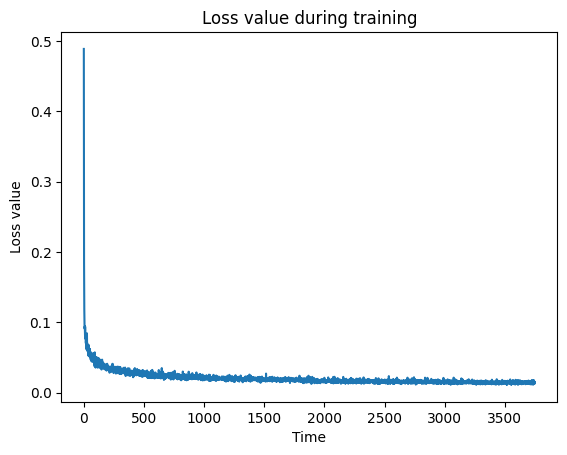

In [177]:
net.plot_train_loss()

In [178]:
image, labels = next(iter(test_loader))
result = net.model(image.to(device))
result = result.detach().cpu()

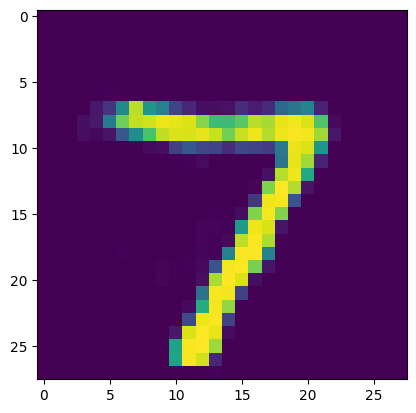

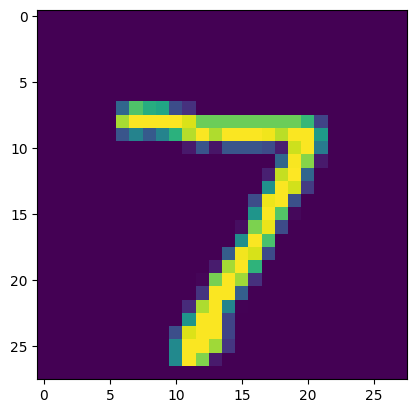

In [179]:
plt.imshow(result[0,0,:,:])
plt.show()
plt.imshow(image[0,0,:,:])
plt.show()

# VQ-VAE (Not Finished)

In [45]:
class VQVAE(nn.Module):
    def __init__(self, in_channels, image_size = (28, 28), latent_size = [32], embedding_size = 16, no_class = 10):
        """
        in_channels - integer: number of channels of input image
        image_size - tuple: size of image
        latent_size - integer: size of latent layers
        embedding_size - integer: size of embedding vector after vector quantization
        depth - integer: how many time the network downsample the image
        length - integer: how many CNN will the image underwent before downsampled
        no_class - integer: number of class in Vector quantization,
        
        """
        super(VQVAE, self).__init__()
        
        # Variable for storing KL loss
        self.loss_VQ = 0

        ##### Encoder
        image_size = torch.tensor(image_size)
        latent_size.insert(0, image_size.prod().item()*in_channels)
        latent_size.append(embedding_size)

        self.latent_encoder = nn.Sequential(
            MLP(*latent_size),
            nn.LeakyReLU()
        ) 

        ##### Embedding module
        self.number_embedding = nn.Embedding(
            num_embeddings=no_class,
            embedding_dim=embedding_size
        )

        ##### Latent space decoder
        self.latent_decoder = nn.Sequential(
            MLP(*latent_size[::-1]),
            nn.Tanh()
        )

        ##### Store the image size to reconstruct it later
        self.latent_image_size = (-1, in_channels, *image_size.tolist())
        
        ##### Initiate the weight
        self.number_embedding.weight.data.uniform_(-1/no_class, 1/no_class)

        
    def forward(self, x, number):
        x = torch.flatten(x, start_dim=1)
        x = self.latent_encoder(x)
        distance_vector = x[:,:,None]-self.number_embedding.weight.permute(1,0).contiguous()[None,:,:]
        distance_vector = distance_vector.norm(dim = 1)
        distance_vector = distance_vector.argmin(dim = 1)
#         embedded_vector = self.number_embedding(number)
        embedded_vector = self.number_embedding.weight[distance_vector]
        self.loss_VQ = F.smooth_l1_loss(x, embedded_vector.detach()) + F.smooth_l1_loss(x.detach(), embedded_vector) + self.diversity_loss()
        x = self.latent_decoder(x)
        x = x.view(self.latent_image_size)
        return x
    
    def diversity_loss(self):
        #Prevent the codebook to collapse
        result = self.number_embedding.weight
        result = result/result.norm(dim = 1).unsqueeze(dim=1)
        result = result@result.T
        return result.mean()
        
        
        
    
    
    
# Test
in_channels = 1
latent_size = [100, 32]
embedding_size = 16
depth = 2
length = 2
image_size = (28, 28)
no_class = 10

test = VQVAE(in_channels, image_size, latent_size, embedding_size, no_class)

x = torch.rand((100, 1, 28, 28))
number = torch.randint(0, no_class, (100,))
print(x.size())
print(test(x, number).size())

torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])


In [71]:
in_channels = 1
image_size = (28, 28)
latent_size = [512, 256]
embedding_size = 32
depth = 2
length = 1
no_class = 32
learning_rate = 1e-3
betas = (0.9, 0.999)

model = VQVAE(in_channels, image_size, latent_size, embedding_size, no_class)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas = betas)
loss_func = nn.SmoothL1Loss()

In [72]:
class VQVAE_Model_Wrapper(Model_Wrapper):
    def train(self, num_epochs, train_loader, beta):
        '''Train model'''
        # Start training
        expected_total_epoch = self.total_train_epoch + num_epochs
        self.loss_reconstruction = []
        self.loss_VQ = []
        for epoch in range(num_epochs):
            self.model.train()
            for i, (data, labels) in enumerate(train_loader, 0):
                # Push data to GPU, clear gradient, calculate loss, backpropagation
                data = data.to(self.device)
                labels = labels.to(self.device)
                # Zero gradient
                self.optimizer.zero_grad()
                # Forward
                output = self.model(data, labels)
                # Calculate the loss
                loss_reconstruction_i = self.loss_function(output, data)
                loss_VQ_i = self.model.loss_VQ
                loss = loss_reconstruction_i + beta*loss_VQ_i
                # Calculate the gradient
                loss.backward()
                # Update the weight
                self.optimizer.step()
                # Store the loss value
                self.train_loss_list.append(loss.item())
                self.loss_reconstruction.append(loss_reconstruction_i.item())
                self.loss_VQ.append(loss_VQ_i.item())
                # print the loss
                if i % 50 == 0:
                    print(f"Epoch: {self.total_train_epoch+1}/{expected_total_epoch}; Data {i*len(labels)}/{len(train_loader.dataset)}; Loss: {loss_reconstruction_i.item()} {loss_VQ_i.item()}")
            self.total_train_epoch += 1

    def test(self, test_loader, beta):
        """Test on test data set"""
        total_loss=[]
        # Test the model
        self.model.eval()
        for i, (data, labels) in enumerate(test_loader, 0):
            # Push data to GPU, predict, and calculate the loss
            data = data.to(device)
            labels = labels.to(device)
            # Predict
            output = self.model(data, labels)
            # Calculate the loss
            loss = self.loss_function(output, data) + beta*self.model.loss_VQ
            # Append the loss
            total_loss.append(loss.item())
            # Calculate performance
            self.calculate_metrics(labels, output)
        # print the loss and metrics
        print(f"Loss: {round(np.array(total_loss).mean(),4)}")
        for metric_name, metric_value in self.calculated_metrics.items():
            print(metric_name, ": ", round(np.array(metric_value).mean(),4), sep="")

net = VQVAE_Model_Wrapper(model, optimizer, loss_func, device)
net.push_to_device()

In [73]:
beta = 1
net.train(2, train_loader, beta)

Epoch: 1/2; Data 0/60000; Loss: 0.4970271587371826 0.14840158820152283
Epoch: 1/2; Data 1600/60000; Loss: 0.09749934077262878 0.005060110241174698
Epoch: 1/2; Data 3200/60000; Loss: 0.0827166959643364 0.005350205581635237
Epoch: 1/2; Data 4800/60000; Loss: 0.07961772382259369 0.002723999787122011
Epoch: 1/2; Data 6400/60000; Loss: 0.08818382769823074 0.0025846678763628006
Epoch: 1/2; Data 8000/60000; Loss: 0.07710829377174377 0.002717317081987858
Epoch: 1/2; Data 9600/60000; Loss: 0.0654633492231369 0.0016174806514754891
Epoch: 1/2; Data 11200/60000; Loss: 0.06150951236486435 0.0018155771540477872
Epoch: 1/2; Data 12800/60000; Loss: 0.06883379817008972 0.0015053285751491785
Epoch: 1/2; Data 14400/60000; Loss: 0.062333665788173676 0.0010576986242085695
Epoch: 1/2; Data 16000/60000; Loss: 0.06397329270839691 0.0008180445292964578
Epoch: 1/2; Data 17600/60000; Loss: 0.0539669506251812 0.0009049446671269834
Epoch: 1/2; Data 19200/60000; Loss: 0.05919087678194046 0.0004312059027142823
Epoch

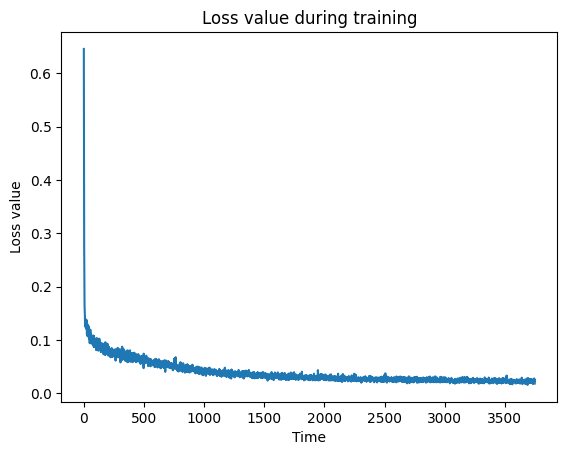

In [74]:
net.plot_train_loss()

In [75]:
net.test(test_loader, beta)

Loss: 0.0182


In [76]:
image, labels = next(iter(test_loader))
result = net.model(image.to(device), labels.to(device))
result = result.detach().cpu()

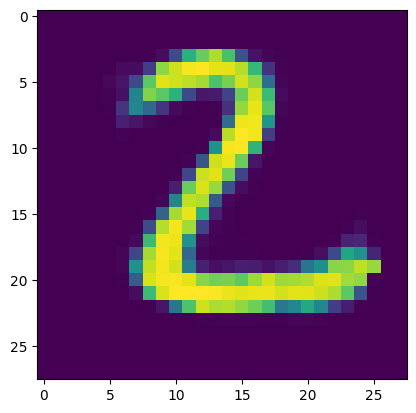

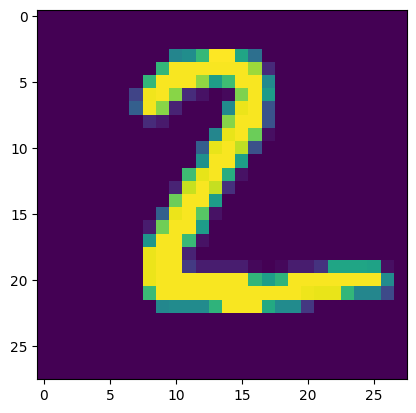

In [77]:
plt.imshow(result[1,0,:,:])
plt.show()
plt.imshow(image[1,0,:,:])
plt.show()

torch.Size([2, 1, 28, 28])


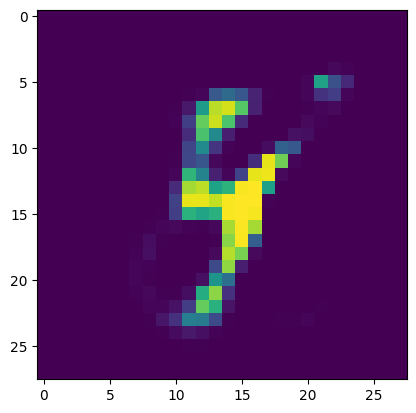

In [83]:
# Sample from the latent space
# latent_size = [512, 256, 32]
net.model.eval()
number = 15
number = torch.tensor([1, number]).to(device)
result = net.model.number_embedding(number)
result = net.model.latent_decoder(result)
result = result.view(net.model.latent_image_size)
result = result.detach().cpu()
print(result.size())
plt.imshow(result[0,0,:,:])
plt.show()